<a href="https://colab.research.google.com/github/FGalvao77/Tutorial-PyTorch/blob/main/_2_Redes_Neurais_Convolucionais_com_PyTorch_%7C_Vis%C3%A3o_Computacional_%7C_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **#2 - Redes Neurais Convolucionais com PyTorch | Visão Computacional | Deep Learning**
---
---

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML
HTML(
    '''<iframe width='560' height='315'
    src='https://www.youtube.com/embed/doT7koXt9vw'
    frameborder='0' allow='accelerometer; autoplay; encryted-media; gyroscope; picture-in-picture'
    allowfullscream></iframe>'''
)

In [ ]:
import torch
import matplotlib.pyplot as plt
import os
import warnings

from torchvision.datasets import CIFAR10

%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [ ]:
DATA_DIR = '/content/drive/MyDrive/CIFAR10'

In [ ]:
cifar10_train = CIFAR10(DATA_DIR, train=True, download=True)
cifar10_test = CIFAR10(DATA_DIR, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(cifar10_train), len(cifar10_test)

(50000, 10000)

In [ ]:
CATEGORIES = ['airplane',       # avião
              'automobile',     # automovél
              'bird',           # pássaro
              'cat',            # gato
              'deer',           # cervo
              'dog',            # cão
              'frog',           # sapo
              'horse',          # cavalo
              'ship',           # navio
              'truck'           # caminhão
]          

In [ ]:
def lookat_dataset(dataset, istensor=False):
    
    fig = plt.figure(figsize=(18, 18))
    rows, cols = 4, 5

    for i in range(1, 21):
        sample_idx = torch.randint(len(dataset), size=(1, )).item()
        img, label = dataset[sample_idx]

        fig.add_subplot(rows, cols, i)
        plt.title(CATEGORIES[label])
        plt.axis('off')

        if istensor:
            plt.imshow(img.squeeze().permute(1, 2, 0))
        else:
            plt.imshow(img)
    
    plt.show();

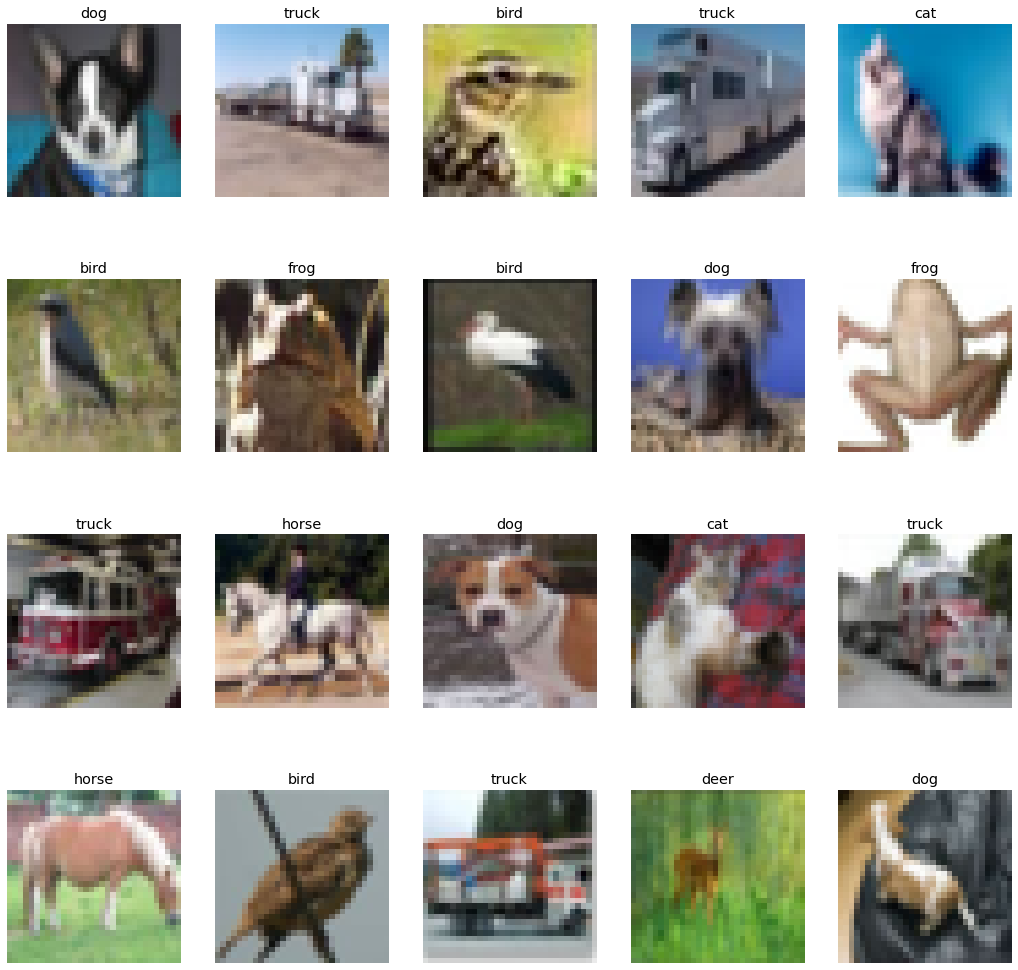

In [ ]:
# lookat_dataset(cifar10_train)
lookat_dataset(dataset=cifar10_train, istensor=False)

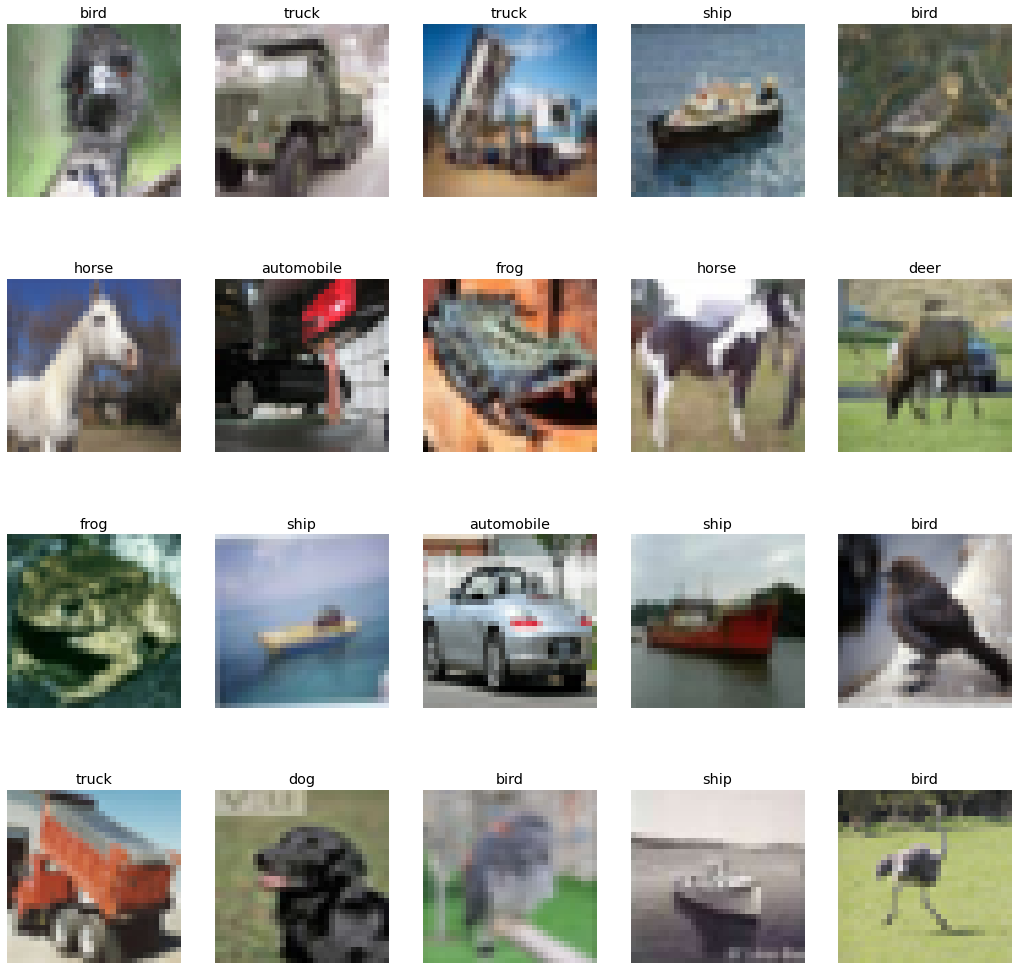

In [ ]:
# lookat_dataset(cifar10_test)
lookat_dataset(dataset=cifar10_test, istensor=False)

In [ ]:
import torchvision.transforms as T

In [ ]:
prep_transform = T.Compose(
    [T.ToTensor()]
)

In [ ]:
tensor_train = CIFAR10(DATA_DIR, train=True,
                       download=False, transform=prep_transform)

tensor_test = CIFAR10(DATA_DIR, train=False,
                       download=False, transform=prep_transform)

In [ ]:
imgs = torch.stack(
    [img_t for img_t, _ in tensor_train], 
    dim=3
)

In [ ]:
imgs.shape  
# 3 = canais de cores | 32, 32 = tamanho da imagem: largura X comprimento | 50.000 = quantidade de imagens

torch.Size([3, 32, 32, 50000])

In [ ]:
# média dos valores dos pixels
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [ ]:
# desvio-padrão dos valores dos pixels
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [ ]:
prep_transform = T.Compose(
    [T.ToTensor(),
     T.Normalize(
         (0.4914, 0.4822, 0.4465), 
         (0.2470, 0.2435, 0.2616))]
)

tensor_train = CIFAR10(DATA_DIR, train=True,
                       download=False, transform=prep_transform)

tensor_test = CIFAR10(DATA_DIR, train=False,
                       download=False, transform=prep_transform)

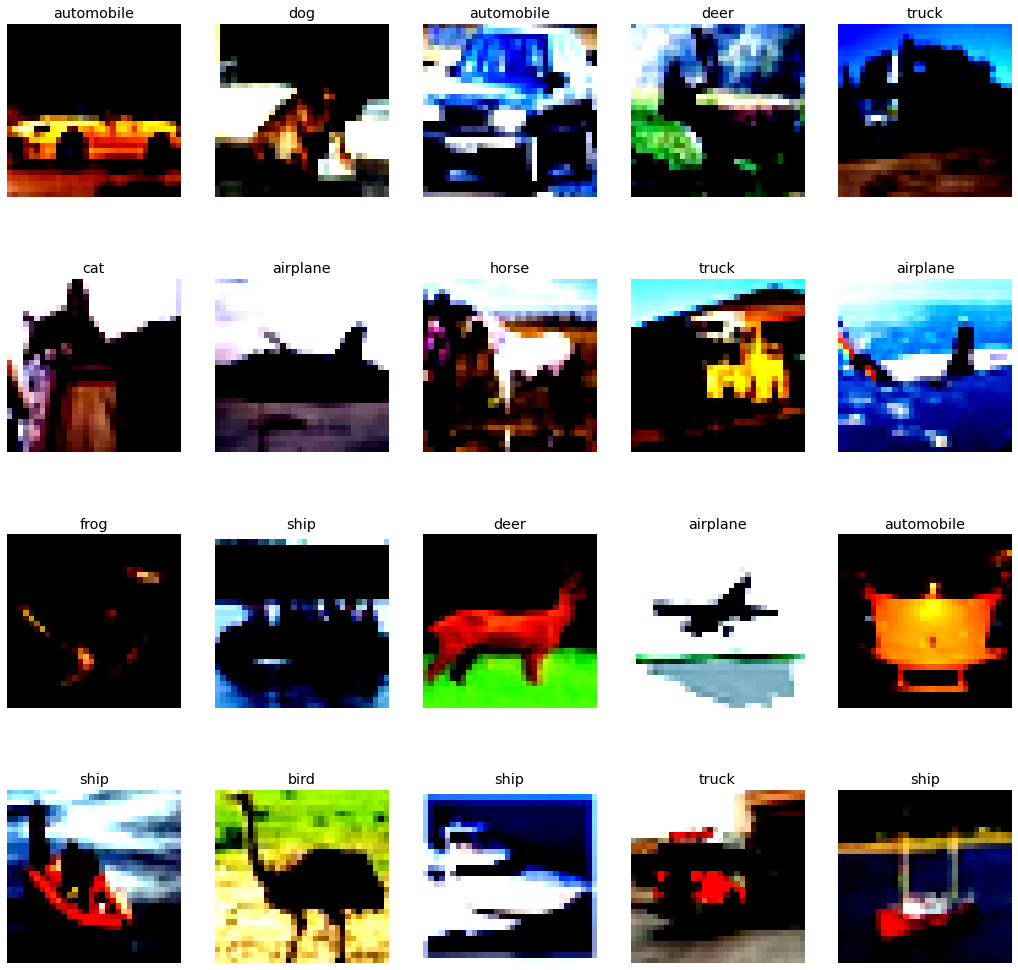

In [ ]:
lookat_dataset(dataset=tensor_train, istensor=True)

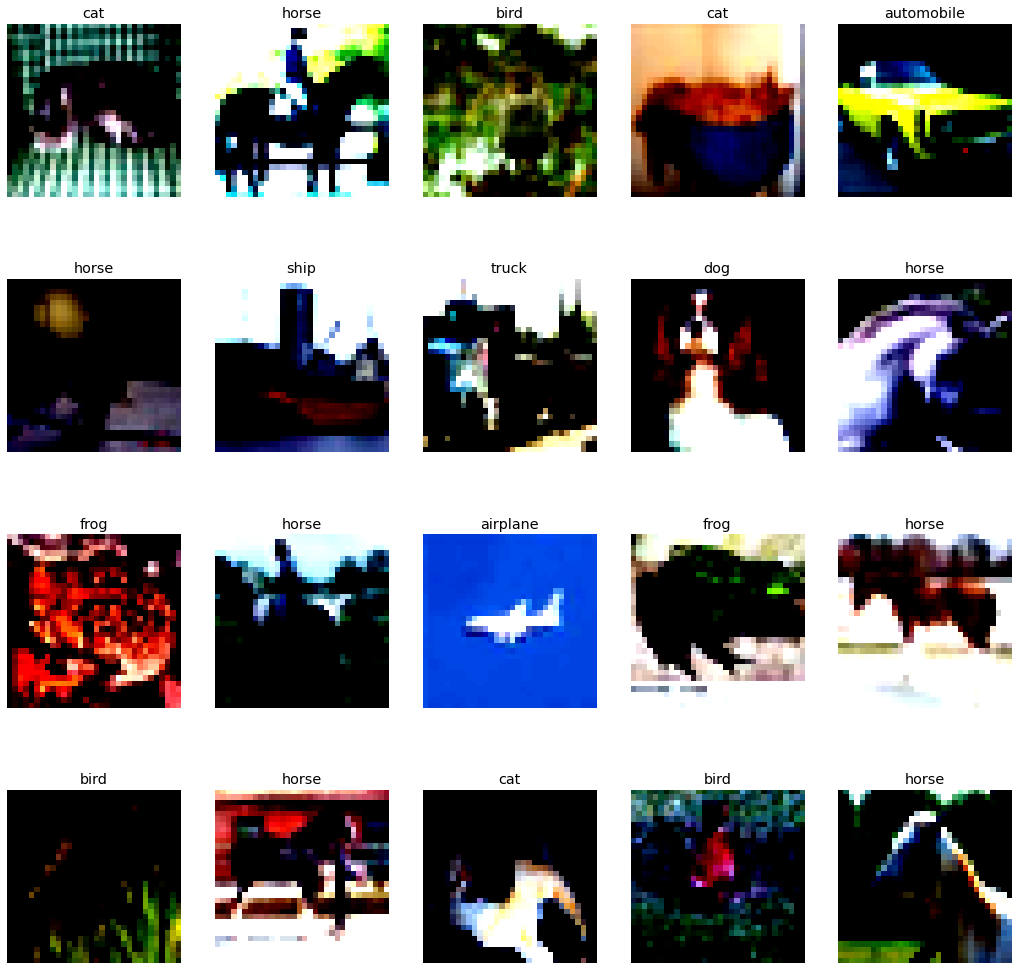

In [ ]:
lookat_dataset(dataset=tensor_test, istensor=True)

In [ ]:
from torch.utils.data.dataloader import DataLoader

In [ ]:
batch_size = 64 

train_loader =  DataLoader(dataset=tensor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=tensor_test, batch_size=batch_size, shuffle=True)

In [ ]:
from torch import nn

In [ ]:
class MLPClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.layers = nn.Sequential(
            nn.Linear(3 * 32*32, 256), 
            nn.ReLU(),
            nn.Linear(256, 128), 
            nn.ReLU(),
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        vector_ = self.flatten(x)
        return self.layers(vector_)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Running... {device}')

Running... cpu


In [ ]:
model = MLPClassifier().to(device)

model

MLPClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [ ]:
lossFunc = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=1e-3)  # 0.001

In [ ]:
def train(model, dataloader, loss_func, optimizer):
    model.train()
    cum_loss = 0.0

    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        pred = model(imgs)
        loss = loss_func(pred, labels)
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()

    return cum_loss / len(dataloader)

In [ ]:
def validate(model, dataloader, loss_func):
    model.eval()
    cum_loss = 0.0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            pred = model(imgs)
            loss = loss_func(pred, labels)
            cum_loss += loss.item()

    return cum_loss / len(dataloader)

In [ ]:
epochs = 101 
train_losses = []
test_losses = []

for epoch in range(epochs):
    # train_loss = train(model, train_loader, lossFunc, opt)
    train_loss = train(model=model, dataloader=train_loader, loss_func=lossFunc, optimizer=opt)
    train_losses.append(train_loss)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss}')

    # test_loss = validate(model, test_loader, lossFunc)
    test_loss = validate(model=model, dataloader=test_loader, loss_func=lossFunc)
    test_losses.append(test_loss)

Epoch: 0 | Train Loss: 2.3044902253943635
Epoch: 10 | Train Loss: 2.1042486822513666
Epoch: 20 | Train Loss: 1.869259362025639
Epoch: 30 | Train Loss: 1.7017826971495549
Epoch: 40 | Train Loss: 1.548416514530816
Epoch: 50 | Train Loss: 1.4293345723615583
Epoch: 60 | Train Loss: 1.3244122133383056
Epoch: 70 | Train Loss: 1.2241096303743475
Epoch: 80 | Train Loss: 1.126899574418812
Epoch: 90 | Train Loss: 1.030048044822405
Epoch: 100 | Train Loss: 0.9317598851288066


In [ ]:
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()

    for loss_name, loss_values in losses.items():
        ax.plot(loss_values, label=loss_name)

    ax.legend(fontsize='16')
    ax.set_xlabel('Iteration', fontsize='16')
    ax.set_ylabel('Loss', fontsize='16')
    ax.set_title('Loss VS Interations', fontsize='16');

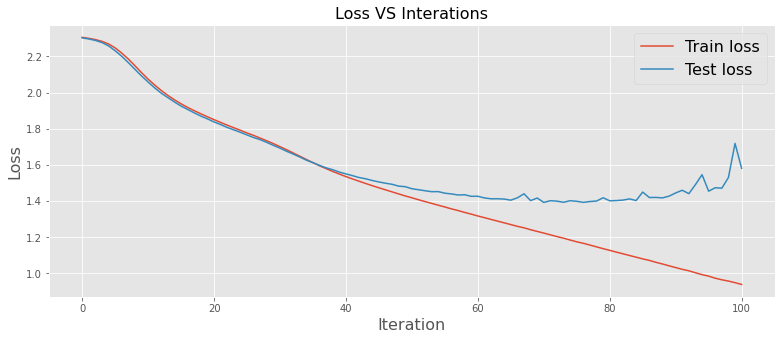

In [ ]:
losses_model = {'Train loss': train_losses,
                'Test loss': test_losses}

plot_losses(losses=losses_model)

In [ ]:
HTML('''<iframe width='560' height='315' 
        src='https://www.youtube.com/embed/ePZswmBSLvc'
        frameborder='0' allow='accelerometer; autoplay; encrypted-media; 
        gyroscope; picture-in-picture' allowfullscreen></iframe>''')

In [ ]:
def make_confusion_matrix(model, loader, n_classes):
    confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)

    with torch.no_grad():
        for i, (imgs, labels) in enumerate(loader):
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)

            for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1), 
                            torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
                confusion_matrix[t, p] += 1

        return confusion_matrix

In [ ]:
def evaluate_accuracy(model, dataloader, classes, verbose=True):
    correct_pred = {classname:0 for classname in classes}
    total_pred = {classname:0 for classname in classes}

    confusion_matrix = make_confusion_matrix(model, dataloader, len(classes))

    if verbose:
        total_correct = 0.0
        total_prediction =0.0

        for i, classname in enumerate(classes):
            correct_count = confusion_matrix[i][i].item()
            class_pred = torch.sum(confusion_matrix[i]).item()

            total_correct += correct_count
            total_prediction += class_pred

            accuracy = 100 * float(correct_count) / class_pred
            print('Accuracy for class {:5s} is: {:.1f}%'.format(classname, accuracy))

    print('Global accuracy is {:.1f}'.format(100 * total_correct / total_prediction))
    
    return confusion_matrix

In [ ]:
def test(model, dataloader, classes):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)

          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  # print accuracy for each class
  total_correct = 0.0
  total_prediction = 0.0

  for classname, correct_count in correct_pred.items():
      total_correct += correct_count
      total_prediction += total_pred[classname]
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print('Accuracy for class {:5s} is: {:.1f} %'.format(classname,accuracy))

  print('Global acccuracy is {:.1f}'.format(100 * total_correct / total_prediction))

In [ ]:
# confusion_matrix = evaluate_accuracy(model, test_loader, CATEGORIES)
confusion_matrix = evaluate_accuracy(model=model, dataloader=test_loader, classes=CATEGORIES)

Accuracy for class airplane is: 53.3%
Accuracy for class automobile is: 64.5%
Accuracy for class bird  is: 32.9%
Accuracy for class cat   is: 32.9%
Accuracy for class deer  is: 37.8%
Accuracy for class dog   is: 37.4%
Accuracy for class frog  is: 60.1%
Accuracy for class horse is: 58.5%
Accuracy for class ship  is: 55.6%
Accuracy for class truck is: 57.4%
Global accuracy is 49.0


In [ ]:
import seaborn as sns

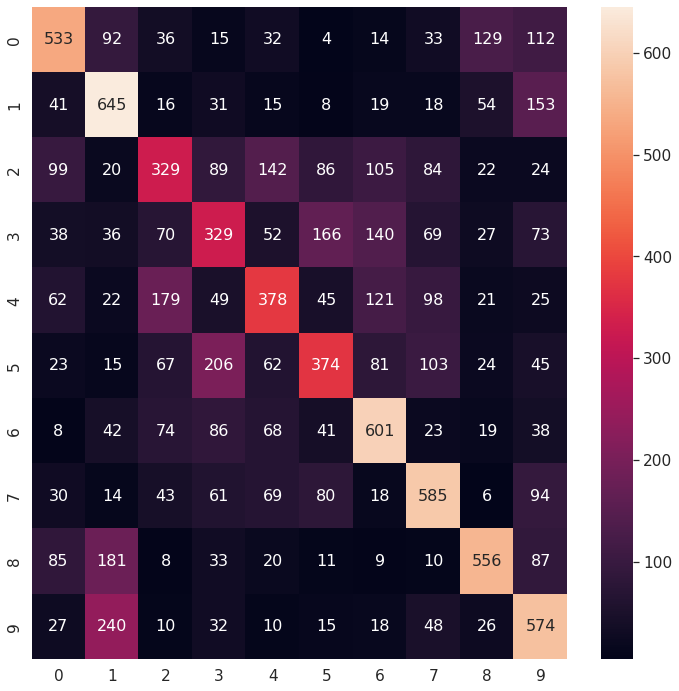

In [ ]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.4)

sns.heatmap(data=confusion_matrix.tolist(), 
           annot=True, annot_kws={'size': 16}, fmt='d');

In [ ]:
HTML('''<iframe width='560' height='315'
        src='https://www.youtube.com/embed/uHT4qDzq1bY'
        frameborder='0' allow='accelerometer; autoplay; encrypted-media; 
        gyroscope; picture-in-picture' allowfullscreen></iframe>''')

In [ ]:
class ConvolutionalNetworkModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.linearlayers = nn.Sequential(
            nn.Linear(1152, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.convlayers(x)
        x = torch.flatten(x, 1)

        return self.linearlayers(x)

In [ ]:
convModel = ConvolutionalNetworkModel().to(device)
convModel

ConvolutionalNetworkModel(
  (convlayers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linearlayers): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
lossFunc2 = nn.CrossEntropyLoss()
opt2 = torch.optim.SGD(convModel.parameters(), lr=1e-3)  # 0.001

In [ ]:
epochs = 101 

conv_train_losses = []
conv_test_losses = []

for epoch in range(epochs):
    train_loss2 = train(model=convModel, dataloader=train_loader, loss_func=lossFunc2, optimizer=opt2)
    conv_train_losses.append(train_loss2)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Train loss: {train_loss2}')
    
    test_loss2 = validate(model=convModel, dataloader=test_loader, loss_func=lossFunc2)
    conv_test_losses.append(test_loss2)

Epoch: 0 | Train loss: 2.293843862040878
Epoch: 10 | Train loss: 1.7251264899587997
Epoch: 20 | Train loss: 1.4802993726547418
Epoch: 30 | Train loss: 1.349680997602775
Epoch: 40 | Train loss: 1.244185824757037


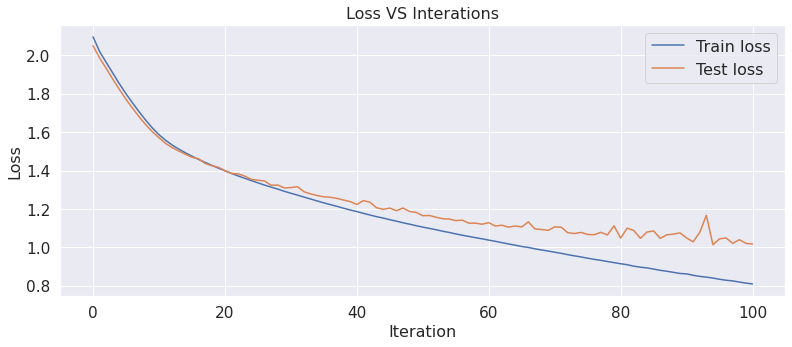

In [ ]:
convModel_losses = {
    'Train loss': conv_train_losses,
    'Test loss': conv_test_losses
}

plot_losses(losses=convModel_losses)

In [ ]:
convModel_confusion_matrix = evaluate_accuracy(
    model=convModel, dataloader=test_loader, classes=CATEGORIES
)

Accuracy for class airplane is: 65.8%
Accuracy for class automobile is: 70.6%
Accuracy for class bird  is: 43.6%
Accuracy for class cat   is: 51.8%
Accuracy for class deer  is: 70.9%
Accuracy for class dog   is: 53.1%
Accuracy for class frog  is: 71.6%
Accuracy for class horse is: 67.8%
Accuracy for class ship  is: 85.7%
Accuracy for class truck is: 71.6%
Global accuracy is 65.2


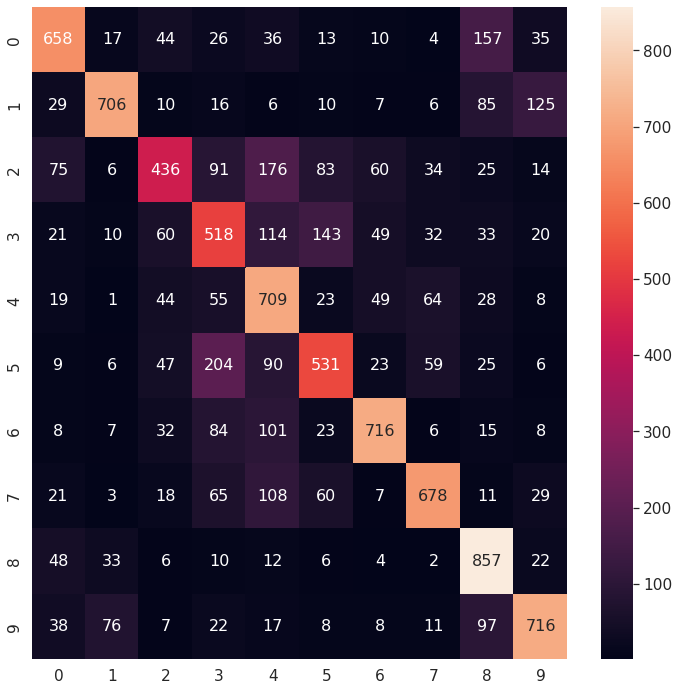

In [ ]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.4)

sns.heatmap(
    data=convModel_confusion_matrix.tolist(),
    annot=True, annot_kws={'size':16}, fmt='d'
);

In [ ]:
from PIL import Image

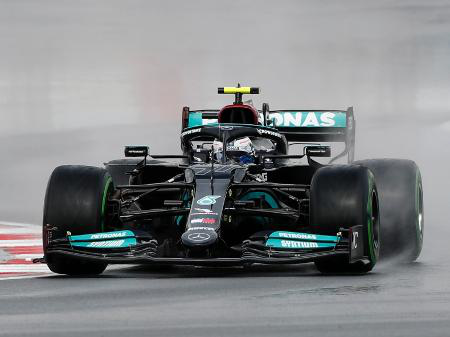

In [ ]:
# img_test = Image.open('/content/drive/MyDrive/CIFAR10/carroF1.png')
img_test = Image.open('/content/drive/MyDrive/imagens_teste/formula1.png')
img_test 

In [ ]:
prep_transform = T.Compose(
    [T.Resize((32, 32)),
     T.ToTensor(),
     T.Normalize((0.4914, 0.4822, 0.4465), 
                 (0.2470, 0.2435, 0.2616))]
)

img_tensor = prep_transform(img_test)
img_tensor

tensor([[[0.7255, 0.7413, 0.7731,  ..., 0.4556, 0.4873, 0.5032],
         [0.7413, 0.7413, 0.7572,  ..., 0.5032, 0.4873, 0.4556],
         [0.7731, 0.7890, 0.7731,  ..., 0.6143, 0.5667, 0.5508],
         ...,
         [0.2015, 0.2492, 0.2650,  ..., 0.4556, 0.4873, 0.4873],
         [0.4873, 0.4873, 0.4714,  ..., 0.2492, 0.2492, 0.2492],
         [0.3285, 0.3127, 0.2809,  ..., 0.1380, 0.1380, 0.1539]],

        [[0.7898, 0.8059, 0.8220,  ..., 0.5160, 0.5482, 0.5643],
         [0.7898, 0.7898, 0.8059,  ..., 0.5643, 0.5482, 0.5160],
         [0.8220, 0.8381, 0.8381,  ..., 0.6609, 0.6287, 0.6126],
         ...,
         [0.3066, 0.3227, 0.3710,  ..., 0.5160, 0.5482, 0.5482],
         [0.5482, 0.5482, 0.5321,  ..., 0.3227, 0.3388, 0.3227],
         [0.4033, 0.3710, 0.3388,  ..., 0.2422, 0.2422, 0.2583]],

        [[0.9016, 0.9166, 0.9316,  ..., 0.6767, 0.7067, 0.7217],
         [0.9016, 0.9016, 0.9166,  ..., 0.7067, 0.6917, 0.6767],
         [0.9316, 0.9466, 0.9316,  ..., 0.7817, 0.7667, 0.

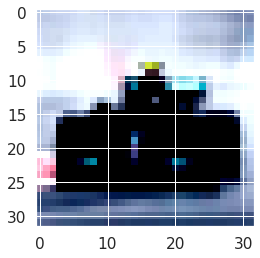

In [ ]:
plt.imshow(img_tensor.permute(1, 2, 0));

In [ ]:
batch = img_tensor.unsqueeze(0).to(device)
batch

tensor([[[[0.7255, 0.7413, 0.7731,  ..., 0.4556, 0.4873, 0.5032],
          [0.7413, 0.7413, 0.7572,  ..., 0.5032, 0.4873, 0.4556],
          [0.7731, 0.7890, 0.7731,  ..., 0.6143, 0.5667, 0.5508],
          ...,
          [0.2015, 0.2492, 0.2650,  ..., 0.4556, 0.4873, 0.4873],
          [0.4873, 0.4873, 0.4714,  ..., 0.2492, 0.2492, 0.2492],
          [0.3285, 0.3127, 0.2809,  ..., 0.1380, 0.1380, 0.1539]],

         [[0.7898, 0.8059, 0.8220,  ..., 0.5160, 0.5482, 0.5643],
          [0.7898, 0.7898, 0.8059,  ..., 0.5643, 0.5482, 0.5160],
          [0.8220, 0.8381, 0.8381,  ..., 0.6609, 0.6287, 0.6126],
          ...,
          [0.3066, 0.3227, 0.3710,  ..., 0.5160, 0.5482, 0.5482],
          [0.5482, 0.5482, 0.5321,  ..., 0.3227, 0.3388, 0.3227],
          [0.4033, 0.3710, 0.3388,  ..., 0.2422, 0.2422, 0.2583]],

         [[0.9016, 0.9166, 0.9316,  ..., 0.6767, 0.7067, 0.7217],
          [0.9016, 0.9016, 0.9166,  ..., 0.7067, 0.6917, 0.6767],
          [0.9316, 0.9466, 0.9316,  ..., 0

In [ ]:
convModel.eval()

ConvolutionalNetworkModel(
  (convlayers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linearlayers): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
output = convModel(batch)
output

tensor([[ 1.1587e+00,  4.3210e+00, -3.5791e+00,  7.2050e-01, -1.1587e-03,
         -2.7846e+00, -2.1330e+00, -2.3173e+00,  1.9546e+00,  3.2541e+00]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
logits = torch.nn.functional.softmax(input=output, dim=1) * 100
prob_dict ={}

for i, classname in enumerate(CATEGORIES):
    prob = logits[0][i].item()
    print(f'{classname} score [probability]: {prob:.2f}%')
    prob_dict[classname] = [prob]

airplane score [probability]: 2.78%
automobile score [probability]: 65.58%
bird score [probability]: 0.02%
cat score [probability]: 1.79%
deer score [probability]: 0.87%
dog score [probability]: 0.05%
frog score [probability]: 0.10%
horse score [probability]: 0.09%
ship score [probability]: 6.15%
truck score [probability]: 22.56%


In [ ]:
import pandas as pd

In [ ]:
df_prob = pd.DataFrame.from_dict(prob_dict)

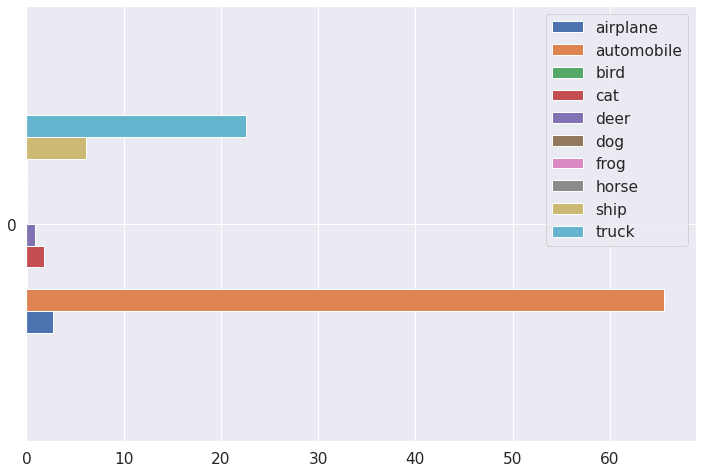

In [ ]:
df_prob.plot(kind='barh', figsize=(12, 8));

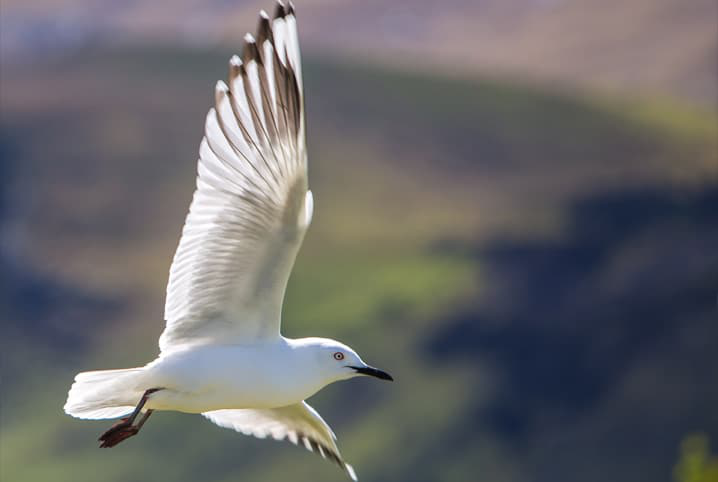

In [ ]:
# img_test2 = Image.open('/content/drive/MyDrive/CIFAR10/passaro.jpg')
img_test2 = Image.open('/content/drive/MyDrive/imagens_teste/passaro.jpg')
img_test2

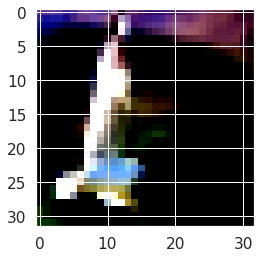

In [ ]:
prep_transform = T.Compose(
    [T.Resize((32, 32)),
     T.ToTensor(),
     T.Normalize((0.4914, 0.4822, 0.4465), 
                 (0.2470, 0.2435, 0.2616))]
)

img_tensor2 = prep_transform(img_test2)

plt.imshow(img_tensor2.permute(1, 2, 0));

In [ ]:
batch2 = img_tensor2.unsqueeze(0).to(device)

convModel.eval

<bound method Module.eval of ConvolutionalNetworkModel(
  (convlayers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linearlayers): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)>

In [ ]:
output2 = convModel(batch2)
output2

tensor([[-1.5991, -3.7626,  2.6244,  4.0763,  0.8483,  1.9640,  0.3722,  0.0044,
          2.4015, -0.9350]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
logits = torch.nn.functional.softmax(input=output2, dim=1) * 100
prob_dict ={}

for i, classname in enumerate(CATEGORIES):
    prob = logits[0][i].item()
    print(f'{classname} score [probability]: {prob:.2f}%')
    prob_dict[classname] = [prob]

airplane score [probability]: 0.21%
automobile score [probability]: 0.02%
bird score [probability]: 14.33%
cat score [probability]: 61.19%
deer score [probability]: 2.43%
dog score [probability]: 7.40%
frog score [probability]: 1.51%
horse score [probability]: 1.04%
ship score [probability]: 11.46%
truck score [probability]: 0.41%


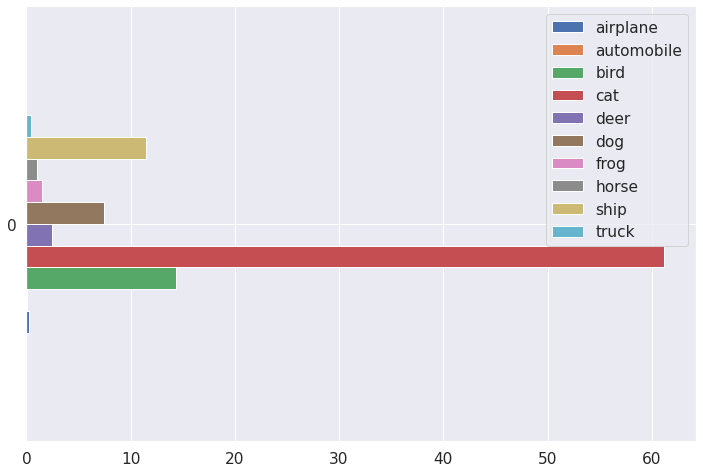

In [ ]:
df_prob = pd.DataFrame.from_dict(prob_dict)

df_prob.plot(kind='barh', figsize=(12, 8));

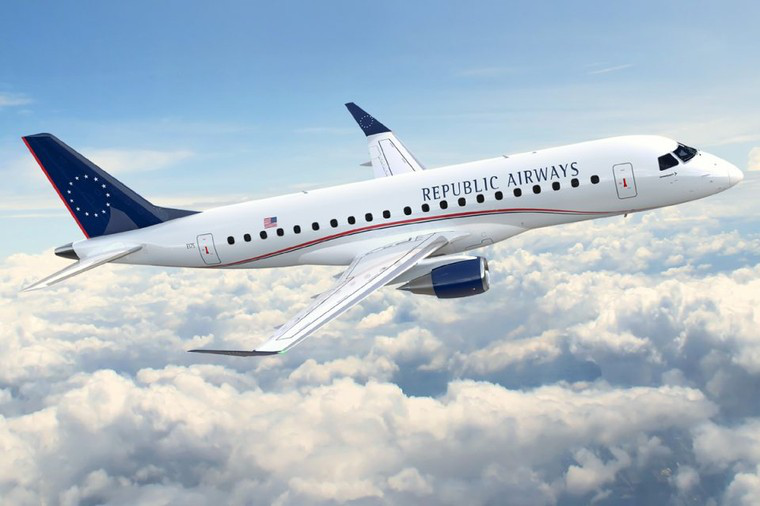

In [ ]:
# img_test3 = Image.open('/content/drive/MyDrive/CIFAR10/aviao.jpg')
img_test3 = Image.open('/content/drive/MyDrive/imagens_teste/aviao.jpg')
img_test3

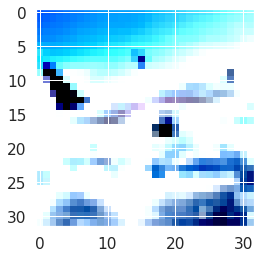

In [ ]:
prep_transform = T.Compose(
    [T.Resize((32, 32)),
     T.ToTensor(),
     T.Normalize((0.4914, 0.4822, 0.4465), 
                 (0.2470, 0.2435, 0.2616))]
)

img_tensor3 = prep_transform(img_test3)

plt.imshow(img_tensor3.permute(1, 2, 0));

In [ ]:
batch3 = img_tensor3.unsqueeze(0).to(device)

convModel.eval

<bound method Module.eval of ConvolutionalNetworkModel(
  (convlayers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linearlayers): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)>

In [ ]:
output3 = convModel(batch3)
output3

tensor([[ 7.6357, -1.8131, -0.3913,  0.8343,  1.6430, -1.9535, -4.4172, -1.4258,
          4.4136, -1.5099]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
logits = torch.nn.functional.softmax(input=output3, dim=1) * 100
prob_dict ={}

for i, classname in enumerate(CATEGORIES):
    prob = logits[0][i].item()
    print(f'{classname} score [probability]: {prob:.2f}%')
    prob_dict[classname] = [prob]

airplane score [probability]: 95.77%
automobile score [probability]: 0.01%
bird score [probability]: 0.03%
cat score [probability]: 0.11%
deer score [probability]: 0.24%
dog score [probability]: 0.01%
frog score [probability]: 0.00%
horse score [probability]: 0.01%
ship score [probability]: 3.82%
truck score [probability]: 0.01%


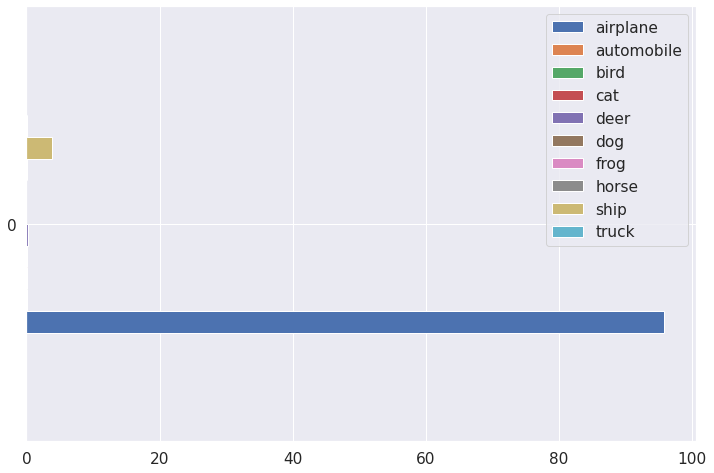

In [ ]:
df_prob = pd.DataFrame.from_dict(prob_dict)

df_prob.plot(kind='barh', figsize=(12, 8));

In [ ]:
%mkdir models

mkdir: cannot create directory ‘models’: File exists


In [ ]:
torch.save(model.state_dict(), '/content/models/mlp_model_weights.pth')

In [ ]:
torch.save(convModel.state_dict(), '/content/models/conv_model_weights.pth')

In [ ]:
HTML('''<iframe width='560' height='315' 
        src='https://www.youtube.com/embed/HW7oJVqqQxU''
        frameborder='0' allow='accelerometer; autoplay; encrypted-media; 
        gyroscope; picture-in-picture' allowfullscreen></iframe>''')

⚠ **Saiba mais!**

1. [Tutorais do PyTorch](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)
2. _Playlist:_ [Machine Learning com Python](https://youtube.com/playlist?list=PL5TJqBvpXQv5CBxLkdqmou_86syFK7U3Q)
3. _Playlist_: [Processamento de Imagens (Programação Dinâmica)](https://www.youtube.com/playlist?list=PL5TJqBvpXQv54i_HWjd7s70vbP4Is7sK_)
4. [Canal Peixe Babel](https://youtu.be/Vfzm1-cfLuc)
5. [Canal Universo Discreto](https://www.youtube.com/watch?v=gbrHEsbTdF0&t=2045s)
6. [Livro Deep Learning](https://www.deeplearningbook.org/), Ian GoodFellow
7. [Fundamentos e Tendências em Visão e Processamento de Imagens](https://www.youtube.com/playlist?list=PLo4jXE-LdDTRaFa39TdNN3FgPAKkcuHvj) [Curso do IMPA]
8. _Playlist:_ [Diário de Pesquisa](https://youtube.com/playlist?list=PL5TJqBvpXQv4xUJmvSPrP2WI--e5KIgux)